# COMP90051 Workshop 9
## Bayesian Regression
***
In this workshop we'll look at Bayesian regression. Briefly, this involves learning a linear regression model from a training set of $(\mathbf{x}, y)$ pairs, where $\mathbf{x}$ is a feature vector and $y$ is a real-valued response variable. Earlier we looked at ridge regression, which involved:
1. assuming a linear relationship between inputs and outputs, i.e., $y \approx \mathbf{w} \cdot \mathbf{x}$ for all pairs
2. minimising the *residual sum of squares error*, that is finding the parameters $\hat{\mathbf{w}}$ that give the best fit to the training responses (with a regularisation term that penalises large weights) 
3. using $\hat{\mathbf{w}}$ to make test inferences

We'll now look at *Bayesian* inference for the above model. 
In this case we don't follow steps 2 and 3 above, but rather formulate the *posterior* over the weights, and make test inferences using *all settings of the weights* according to their posterior probability. 
These operations can be solved exactly, using linear algebra.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
np.random.seed(1)

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import BayesianRidge

### 0. Preliminaries
Now in the course you should be familiar with two methods of estimating parameters to unknown probability distributions. The general problem is, given a sample 
$ X = \{ x_1, \ldots x_n\}$ from some distribution $p(x \vert \theta)$, estimate the underlying parameters $\theta$.

#### Frequentist: 
Use maximum likelihood estimation. Generally reduces to minimizing the negative log-likelihood. Returns a point-estimate.

$$ \theta_{MLE} = \text{argmax}_{\theta}\; p(X \vert \theta) = \text{argmax}_{\theta} \prod_i^n p(x_i \vert \theta) = \text{argmax}_{\theta} \sum_i^n \log p(x_i \vert \theta)$$

#### Bayesian: 

Encode uncertainty / prior knowledge of $\theta$ in the prior distribution $p(\theta)$. Apply Bayes' Theorem during inference to diagnose potential causes. Recover posterior distribution over all possible values. Exact computation typically intractable. 

$$ p(\theta \vert X) = \frac{\prod_i^n p(x_i \vert \theta) p(\theta)}{\int d\theta \prod_i^n p(x_i \vert \theta) p(\theta)}$$

Today we will be using a Bayesian perspective on linear regression, where we assume a data-generating model $p(x \vert \theta)$ and infer the parameters of the distribution from the dataset $X$.

In this worksheet we'll run through the full Bayesian gauntlet:

* Computing the posterior over model parameters, $p(\theta \vert X)$
* Finding the maximum a posteriori (MAP) estimate
* Finding the ensemble average prediction by sampling many $\bf{w}$ from the posterior. (Approximate Bayes)
* Computing the predictive posterior $p(y^* \vert X, \theta, \bf{x}^*)$ for new points $\bf{x}^*$. (Exact Bayes) - only possible in the case where the likelihood and prior are conjugate. 

### 1. Regression data set
Let's generate a small synthetic data set in 1D according to the following model:
$$
\newcommand\ys{\mathbf{y}}
\newcommand\xs{\mathbf{x}}
\newcommand\Xs{\mathbf{X}}
\newcommand\ws{\mathbf{w}}
\newcommand\Vs{\mathbf{V}}
\newcommand\Is{\mathbf{I}}
\begin{align*}
x &\sim \mathrm{Uniform}[0,1] \\
y|x, \sigma^2 &\sim \mathrm{Normal}\!\left[5\left(x - \frac{1}{2}\right)^2, \sigma^2 \right]
\end{align*}
$$
By focusing on the 1D case, it'll be straightforward to visualise the results.
We'll keep the data set small, since Bayesian approaches are particularly useful when limited data is available.

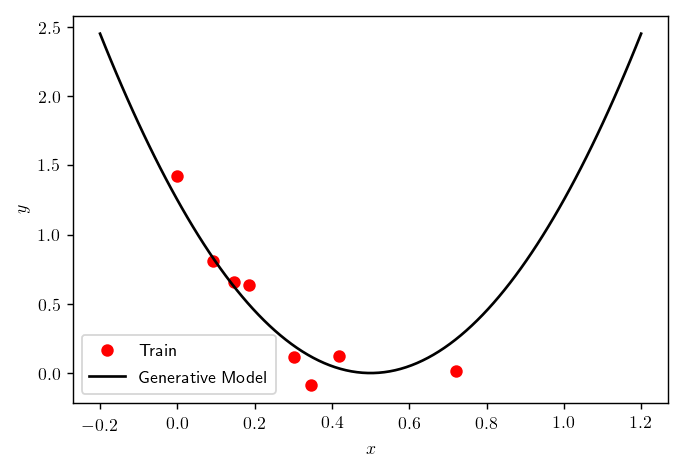

In [2]:
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

# parameters
n_instances = 8
sigma = 0.1 # keep this small: don't want too much noise

# generate data matrix with rows as instances
X = np.random.uniform(size=(n_instances,1))

# generate the target response values using the quadratic function
# and additive noise
Y = np.random.normal(loc=5*(X - 0.5)**2, scale=sigma, size=(n_instances,1)).ravel()

# plot the training data
plt.plot(X, Y, 'ro', label='Train')

# and plot the true function (without noise)
X_test = np.linspace(-0.2, 1.2, 100)
X_test = X_test[:,np.newaxis]
Y_test_gold = 5*(X_test - 0.5)**2 
plt.plot(X_test, Y_test_gold, 'k', label='Generative Model')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

#### Polynomial basis functions
Since the relationship between $y$ and $x$ is non-linear, we'll apply polynomial basis expansion to degree $d$.
Specifically, we replace the original data matrix $\mathbf{X}$ by the transformed matrix below:
$$
\mathbf{\Phi} = \begin{bmatrix}
    1 & x_1 & x_1^2 & \ldots & x_1^d \\
    1 & x_2 & x_2^2 & \ldots & x_2^d \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & x_n & x_n^2 & \ldots & x_n^d \\
\end{bmatrix}
$$
Note that we're including a column of ones to account for the bias term.

The function below is a wrapper around `sklearn.preprocessing.PolynomialFeatures`, which implements the above transformation on a train/test set. We'll pick a maximum polynomial order of 9 to be silly. 

In [3]:
def polynomial_features(X_train, X_test, degree, include_bias=True):
    """
    Augments data matrices X_train and X_test with polynomial features
    """
    poly = PolynomialFeatures(degree=degree, include_bias=include_bias)
    
    Phi_train = poly.fit_transform(X_train)
    Phi_test = poly.fit_transform(X_test)
    
    return Phi_train, Phi_test
    
Phi, Phi_test = polynomial_features(X, X_test, 8)  # This is a silly choice - on purpose! :) 

**Discussion**: How does this basis trick relate to kernel methods? 

**Answer**: This is a nonlinear mapping $\Phi: \mathcal{X} \rightarrow \mathcal{F}$ from the original space $\mathcal{X}$ to a typically higher dimension feature space $\mathcal{F}$. Note that the problem is still linear in $\ws$ and therefore analytically tractable provided the mapping does not depend on the weights. Kernel methods typically compare points in this space by similarity in $\mathcal{F}$, as measured by the inner product $\kappa(x,x') = \langle \Phi(x), \Phi(x') \rangle$. We will see below that it is possible to express the mean of the predictive distribution as target $y_n$ in terms of inner products between feature vectors - this will allow us to replace all occurrences of inner products with the kernel, lifting the whole algorithm into feature space!

### 2. Bayesian regression with known variance

In this section, we're going to implement the Bayesian regression model described in lectures.

Let's begin with a quick recap. The model assumes the data is generated according to a Normal distribution, where the mean is a linear function of the input vector and the variance $\sigma^2$ is **assumed known**. We will be attempting to estimate the mean of the data-generating distribution $\text{Normal}(\mu(\xs), \sigma^2)$, which is allowed to vary with $\xs$.
The prior over the weight vector $\ws$ is an isotropic Normal with zero mean and covariance matrix $\gamma^2 \mathbb{1}$ — we expect weights with smaller magnitude to be _a priori_ more probable. The prior is independent for each weight with shared variance $\gamma^2$, which controls the strength of our a priori beliefs.
$$
\begin{align*}
\ws | \gamma &\sim \mathrm{Normal}\!\left[\mathbf{0}, \gamma^2 \mathbf{I}_m\right] & \mbox{Prior} \\
y | \mathbf{x}, \mathbf{w}, \sigma &\sim \mathrm{Normal}\!\left[\xs^\intercal \ws, \sigma^2\right] & \mbox{Likelihood}
\end{align*}
$$ 

Given this formulation, the next step is to solve for the posterior over $\ws$
$$
\begin{align*}
p(\ws | \Xs, \ys, \sigma, \gamma) = \frac{p(\ys | \Xs, \ws, \sigma) p(\ws | \gamma)}{p(\ys | \Xs, \sigma)} =  \frac{\prod_{i=1}^n p(\ys | \xs_i, \ws, \sigma) p(\ws | \gamma)}{\int_{\ws} d\ws\prod_{i=1}^n p(\ys | \xs_i, \ws, \sigma) p(\ws | \gamma)} 
\end{align*}
$$
where $\Xs \in \mathbb{R}^{n \times D}$ is the feature matrix and $\ys \in \mathbb{R}^{n}$ is the vector of target values for each instance.

In lectures, we derived the following solution:
$$
\ws | \Xs, \ys, \sigma, \gamma \sim  \textrm{Normal}(\ws_N, \mathbf{V}_N)
$$
$$\Vs_N = \sigma^2 \left( \Xs^\intercal \Xs + \frac{\sigma^2}{\gamma^2} \Is_m \right)^{-1}$$

$$\ws_N = \frac{1}{\sigma^2} \Vs_N \Xs^\intercal \ys$$

#### Computing the posterior parameters
Complete the function below to compute the posterior mean $\mathbf{w}_N$ and covariance matrix $\mathbf{V}_N$ for the weights based on the expression above. Remember that `numpy` permits the `@` operator to denote matrix multiplication: `A @ B` = $AB$, where $A$ and $B$ are appropriately sized matrices. Carefully consider what the dimensions of $\ws$, $\Xs$ should be.

In [4]:
def compute_posterior_params(X, Y, sigma, gamma):
    """
    Compute the parameters (mean and covariance) for the posterior over the weights
    
    Arguments
    =========
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    Y : numpy array, shape: (n_instances,)
        target class labels relative to X
    sigma : float
        positive scale parameter for y
    gamma : float
        positive scale parameter for w_i
    
    Returns
    =======
    The following items in a tuple:
    w_N : numpy array, shape: (n_features,)
        mean parameter
    V_N : numpy array, shape: (n_features, n_features)
        covariance parameter
    """
    V_N = sigma**2 * np.linalg.inv(X.T @ X + (sigma/gamma)**2 * np.identity(X.shape[1])) # fill in
    w_N = np.ravel(1/sigma**2 * V_N @ X.T @ Y) # fill in
    
    return w_N, V_N

In [5]:
gamma = 10 # larger implies more permissive, i.e. a more diffuse prior
w_N, V_N = compute_posterior_params(Phi, Y, sigma, gamma)

Let's plot the prior and posterior over $\mathbf{w}$ to see how they differ. 
Since $\mathbf{w}$ is $d+1$-dimensional, we can only visualise the posterior over a couple of the weights.
Here we look at $p(w_1, w_2|\mathbf{X}, \mathbf{y}, \sigma, \gamma)$.

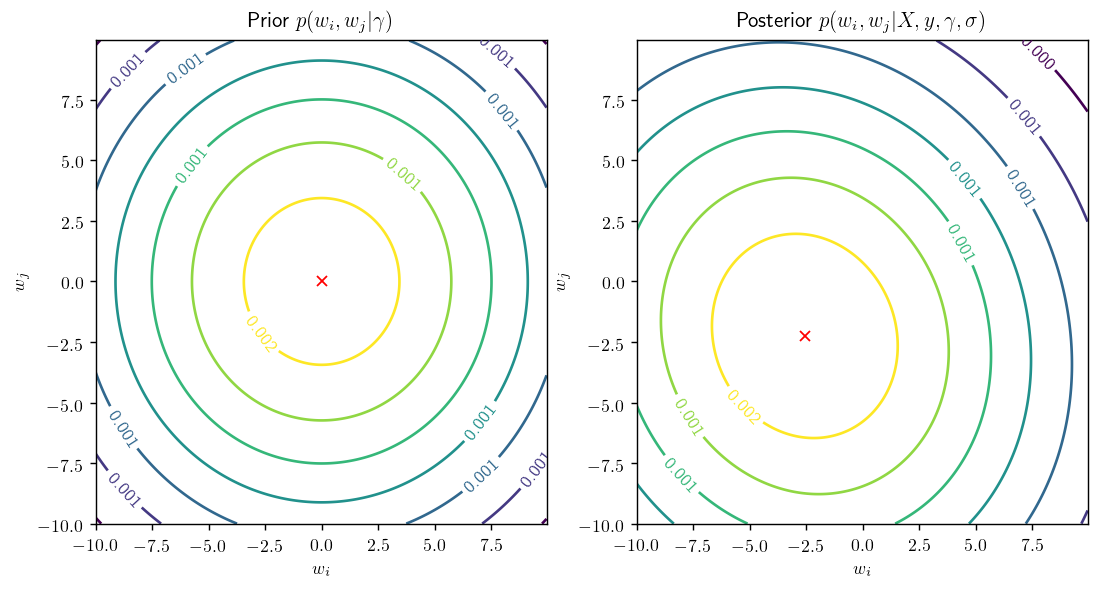

In [6]:
# set up a 2d plot mesh
w1, w2 = np.mgrid[-10:10:.05, -10:10:.05]
grid = np.c_[w1.ravel(), w2.ravel()]

# Which weights do we want to see?
i = 7
j = 8

fig = plt.figure(figsize=(10,5))
# plot a bivariate normal for the prior
ax = fig.add_subplot(121)
p_w = sp.stats.multivariate_normal.pdf(grid, mean=np.zeros(2), cov=gamma**2 * np.identity(2))
CS = ax.contour(w1, w2, p_w.reshape(w1.shape))
plt.clabel(CS, inline=1, fontsize=10)
ax.plot(0, 0, 'rx') # add prior mean
plt.xlabel('$w_i$')
plt.ylabel('$w_j$')
plt.title('Prior $p(w_i, w_j|\gamma)$')

# plot a bivariate normal for the posterior
ax = fig.add_subplot(122)
p_w = sp.stats.multivariate_normal.pdf(grid, mean=[w_N[i],w_N[j]], cov=np.vstack([[V_N[i,i], V_N[i,j]], [V_N[j,i], V_N[j,j]]]))
CS = ax.contour(w1, w2, p_w.reshape(w1.shape))
plt.clabel(CS, inline=1, fontsize=10)
ax.plot(w_N[i], w_N[j], 'rx') # add posterior mean
plt.xlabel('$w_i$')
plt.ylabel('$w_j$')
plt.title('Posterior $p(w_i, w_j|X,y,\gamma,\sigma)$')
plt.show()

**Discussion question**: Can you explain why the prior and the posterior are so different? How is this related to the dataset? Why are the ellipses in the posterior not aligned to the axes? *You might want to change the parameter indices from 0,1 to other pairs to get a better idea of the full posterior.*

#### Bayesian inference
One way of doing inference for $y|\mathbf{x}$ is to draw a sample of weight vectors from the posterior (in this case, sampling from a Gaussian is analytically tractable). For each sampled weight we compute the associated prediction $y^* = \langle \ws, \xs^* \rangle$ on the test point $\xs^*$. We can then compute the empirical mean and variance over all samples to form the ensemble average prediction. In this toy example the mean is of couse $\ws_N$.

Complete the function below to compute the predictive mean $E[y|\mathbf{x}] = \langle \mathbf{w}, \mathbf{x}\rangle$. 
Then run the code block below to plot 50 samples from the posterior.

In [7]:
def target_mean(X, w):
    """
    Compute the predictive mean for the target variable, given X and w
    
    Arguments
    =========
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    w : numpy array, shape: (n_features,)
        weights vector
    
    Returns
    =======
    Y_mean : numpy array, shape: (n_instances,)
        predictive mean for each instance in X
    """
    # your code here
    return np.dot(X, w)

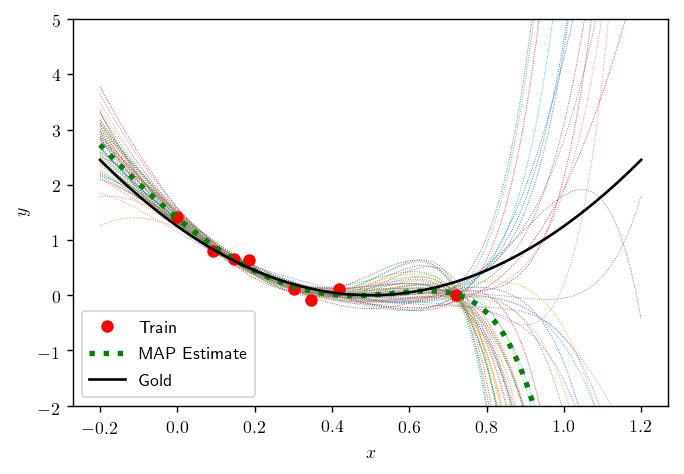

In [8]:
# generate some samples from the posterior
for i in range(50):
    # draw a weight vector
    w_i = np.random.multivariate_normal(w_N, V_N, 1).ravel()
    # plot the predictions for this weight vector for every point in X_test
    p = plt.plot(X_test.ravel(), target_mean(Phi_test, w_i), ':', lw=0.5)

plt.plot(X, Y, 'ro', label='Train')
plt.plot(X_test, target_mean(Phi_test, w_N), 'g:', label='MAP Estimate', lw=3)
plt.plot(X_test.ravel(), Y_test_gold, 'k', label='Gold')

plt.ylim(-2,5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

It's interesting to see what happens near the training data points, and away from them, in particular the edges of the plot. We'll come back to this.

### The Bayesian Predictive Distribution

The parameters of our model $\ws$ are only useful to generate predictions $\mathbb{E}[y \vert \xs]  = \langle \xs, \ws \rangle$. The 'full Bayesian' approach integrates/marginalizes the uncertain parameters $\ws$ to obtain the predictive distribution for some test point $\xs^*$.

$$ p(y^* \vert \xs^*, X_{train}, Y_{train}, \sigma^2, \gamma^2) = \int d \ws \; \text{likelihood} \times \text{posterior} = \int d \ws \; p(y^* \vert \xs^*, \ws, \sigma^2)\; p (\ws \vert X_{train}, Y_{train}, \gamma^2) $$

This essentially takes a weighted average of the model likelihood $p(y^* \vert \xs^*, \ws)$ for all possible values of $\ws$, weighted by the posterior probability $p (\ws \vert X_{train}, Y_{train})$. Note that the final distribution does not contain any $\ws$ dependency. It is worth taking a few minutes to ensure you understand how we obtain the predictive distribution for $y^*$. Viewed in another way, we are averaging the output of all linear models in $\ws$ with the normal posterior over $\ws$.

Thanks to conjugacy, the predictive distribution can be found in closed form in our toy problem.
$$
\begin{align*}
y_{*} | \xs_{*}, \ws_N, \Vs_N, \sigma &= \mathrm{Normal}\!\left[\langle \xs^*, \ws_N\rangle , \sigma^2_N(\xs^*)\right] \\
\sigma^2_N(\xs^*) & = \sigma^2 + (\xs^*)^T \Vs_N \xs^*
\end{align*}
$$

In most real-world applications the prior and likelihood will not enjoy conjugacy and you will be able to compute the predictive log-likelihood. 

Note that the predictive mean is the same as the posterior mean (this is not the case in general - only true for Gaussian conjugate likelihood and prior). It is important to understand the form of the variance of the predictive distribution. Note that it depends on both the test point $\xs^*$ and the training data in the form of $\Vs_N$. It is composed of two terms - the first, $\sigma^2$, is the prior variance, which is due to noise in the data. The second term $\xs^* \Vs_N \xs^*$ is due to uncertainty associated with the parameters $\ws$ due to having a finite training set. Let us consider the simple case of just one training point, $\xs_0$ and one test point $\xs^*$. Then expanded out, the predictive variance is:

$$ 
\begin{align*}
\sigma^2(\xs^*) &= \gamma^2 + \frac{1}{\gamma^2} \phi^T(\xs_0) \phi(\xs_0) - \frac{\left[\phi^T(\xs_0) \phi(\xs_0)\right]^2}{\gamma^6 + \gamma^2 \phi^T(\xs_0) \phi(\xs_0)} \\
&= \gamma^2 + \kappa(\xs_0, \xs_0) - \frac{\kappa^2(\xs_0, \xs^*)}{\gamma^2 + \kappa(\xs_0, \xs_0)} 
\end{align*}
$$

In the second line we realize we can apply the kernel trick to the inner product between feature maps $\kappa(\xs, \xs') = \phi^T(\xs) \phi(\xs')$. This forms the foundation for Bayesian modelling with _Gaussian processes_, a very useful topic that sadly we won't go into. 

Complete the function below to evaluate the predictive standard deviation, i.e. $\sigma_N(\mathbf{x}_{*})$. 
Then run the following code block to plot the results.

In [9]:
def target_std(X, V_N, sigma):
    """
    Compute the predictive standard deviation for the target variable, given X, V_N and sigma
    
    Arguments
    =========
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    V_N : numpy array, shape: (n_features, n_features)
        covariance parameter
    
    Returns
    =======
    std : numpy array, shape: (n_instances,)
        predictive standard deviation for each instance in X
    """
    # your code here #
    
    data_noise = sigma**2
    quadratic_form = np.sum(X * np.dot(X, V_N), axis=1)
    
    variance = data_noise + quadratic_form
    std = np.sqrt(variance)
    
    return std

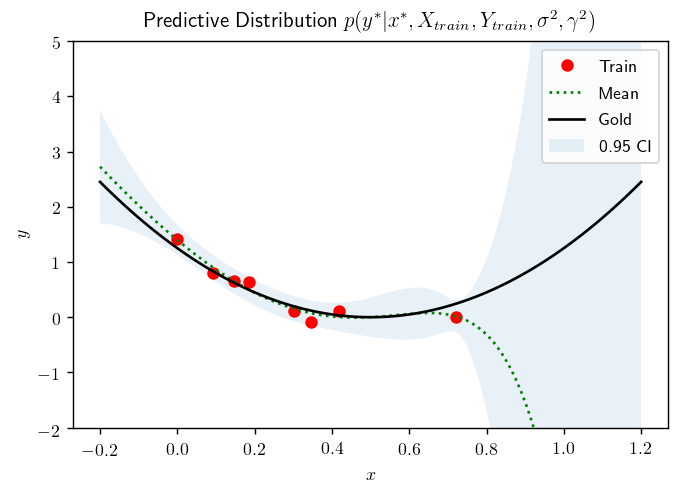

In [10]:
# compute the standard deviation using the formula above
Y_test_mean = target_mean(Phi_test, w_N)
Y_test_std = target_std(Phi_test, V_N, sigma)

plt.plot(X, Y, 'ro', label='Train')
plt.fill_between(X_test.ravel(), Y_test_mean + 2*Y_test_std, Y_test_mean - 2*Y_test_std, alpha=0.1, label='0.95 CI')
plt.plot(X_test.ravel(), Y_test_mean, 'g:', label='Mean')
plt.plot(X_test.ravel(), Y_test_gold, 'k', label='Gold')

plt.ylim(-2,5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.title(r'Predictive Distribution $p(y^* \vert x^*, X_{train}, Y_{train}, \sigma^2, \gamma^2)$')
plt.show()

**Discussion**: How does the uncertainty plot compare to the samples above? How does the uncertainty change relative to the distance from training points? Can you explain why?

**Practical**: How does the setting of `gamma` affect the fit? How about the number of instances in the training set? Try some other values and see what happens. See if you can get some intuition for the roles of $\gamma$ and $\vert X_{train} \vert$ in the uncertainty of the posterior and predictive distributions.

**Discussion**: Is a 9th order polynomial a good choice for this problem? Based on the results above, would you recommend this model, or make a different choice? What is the natural choice to take? Try rerunning the above with what you think is the best choice. We will confirm/refute your intuition below. 

### 3. Bayesian model selection
In this section, we'll revisit the assumption of having a 9th order polynomial. 
The evidence gives us a good way of evaluating the quality of fit.

Note that the evidence (a.k.a. marginal likelihood) is given by integrating out $\ws$ in the model likelihood, weighted by the prior probability $p(\ws)$:
$$
p(\ys|\Xs, \sigma, \gamma) = \int p(\ys | \Xs, \sigma, \gamma, \ws) p(\ws) d \ws
$$
i.e. it's the likelihood function over the space of models for which the parameters $\ws$ have been marginalised out (see Sec 3.4 of Bishop).

We can compare models by comparing the evidence for each model, usually we use the Bayes' Factor, given by the ratio of model evidences.

In [11]:
def evaluate(w, X, Y, sigma, gamma):
    n_instances, n_features = X.shape
    alpha, beta = 1/float(gamma**2), 1/float(sigma**2)
    rss = np.sum((Y - np.dot(X, w))**2)
    wpen = np.dot(w, w)
    E = beta/2.0 * rss + alpha/2.0 * wpen
    A = alpha * np.identity(n_features) + beta * X.T @ X
    lE = n_features/2.0 * np.log(alpha) + n_instances/2.0 * np.log(beta) - E \
        - 0.5 * np.log(np.linalg.det(A)) - n_instances/2.0 * np.log(2.0 * np.pi)
    # return both the evidence, and the RSS term (the raw quality of fit)
    return {'logEvidence': lE, 'RSS': rss}

# what's the evidence for our 9th order model?
evaluate(w_N, Phi, Y, sigma, gamma)

{'logEvidence': -7.207664767336131, 'RSS': 0.07143667429261118}

So what happens if we use a lower order model, e.g., a 3rd order model?

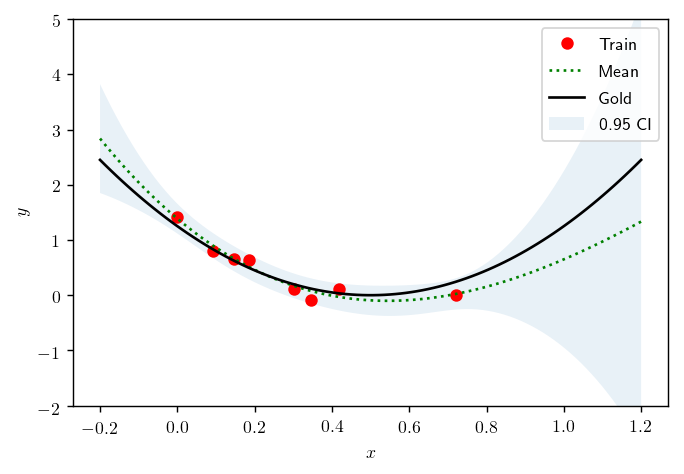

In [12]:
Phi_3, Phi_3_test = polynomial_features(X, X_test, 3)

w_N_3, V_N_3 = compute_posterior_params(Phi_3, Y, sigma, gamma)
Y_test_mean = target_mean(Phi_3_test, w_N_3)
Y_test_std = target_std(Phi_3_test, V_N_3, sigma)
    
plt.plot(X, Y, 'ro', label='Train')
plt.fill_between(X_test.ravel(), Y_test_mean + 2*Y_test_std, Y_test_mean - 2*Y_test_std, alpha=0.1, label='0.95 CI')
plt.plot(X_test.ravel(), Y_test_mean, 'g:', label='Mean')
plt.plot(X_test.ravel(), Y_test_gold, 'k', label='Gold')

plt.ylim(-2,5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

**Discussion**: Does that look like a better fit to you? Consider both the interval $[0,1]$ near the training points, and those outside this range.

Let's see what the *evidence* says, and compare this to the above result:

In [13]:
evaluate(w_N_3, Phi_3, Y, sigma, gamma)

{'logEvidence': -6.6431625493191, 'RSS': 0.07888629421199209}

The RSS has barely changed, but the evidence is much higher. We can look at various model orders to see which has the best *evidence* to perform Bayesian model selection: 

In [14]:
d_range = np.arange(1, 11)
logEvidence = []
RSS = []
for d in d_range:
    Phi_d, Phi_d_test = polynomial_features(X, X_test, d)
    w_N_d, V_N_d = compute_posterior_params(Phi_d, Y, sigma, gamma)
    result = evaluate(w_N_d, Phi_d, Y, sigma, gamma)
    print('Degree {}. Log evidence {}. RSS {}.'.format(d, result['logEvidence'], result['RSS']))
    logEvidence.append(result['logEvidence'])
    RSS.append(result['RSS'])

Degree 1. Log evidence -29.39686607350171. RSS 0.6141638621964031.
Degree 2. Log evidence -5.7484162006696975. RSS 0.08259643223393959.
Degree 3. Log evidence -6.6431625493191. RSS 0.07888629421199209.
Degree 4. Log evidence -6.984455678318592. RSS 0.07653415360637944.
Degree 5. Log evidence -7.122658176161316. RSS 0.07462253729433699.
Degree 6. Log evidence -7.178029861618233. RSS 0.07313020707337617.
Degree 7. Log evidence -7.199556191663649. RSS 0.07209367222456221.
Degree 8. Log evidence -7.207664767336131. RSS 0.07143667429261118.
Degree 9. Log evidence -7.210639596237662. RSS 0.07104621847390613.
Degree 10. Log evidence -7.2117125959468105. RSS 0.07082434587879342.


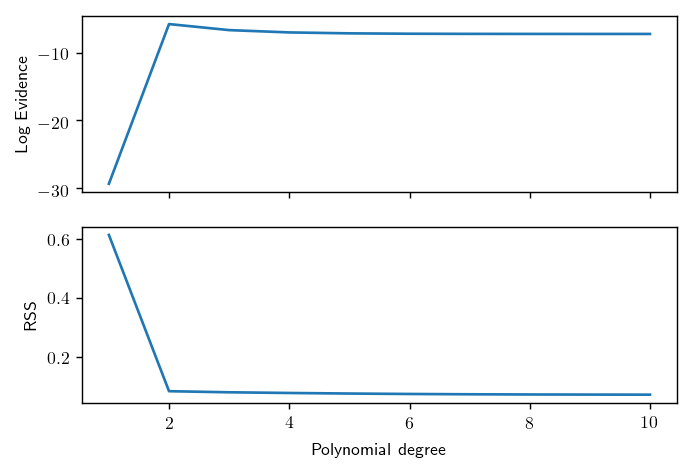

In [15]:
#plot the above log evidence values against the model order
ax1 = plt.subplot(211)
ax1.plot(d_range, logEvidence)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('Log Evidence')

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(d_range, RSS)
plt.xlabel('Polynomial degree')
plt.ylabel('RSS')
plt.show()

**Discussion**: So which model class will be chosen? Is this a reasonable situation? 

**Practical**: Rerun the code with a new random training set, or different values of *N*, such as 2 or 3 points or 20; the results may be different. Can you explain why the outcome might be different?

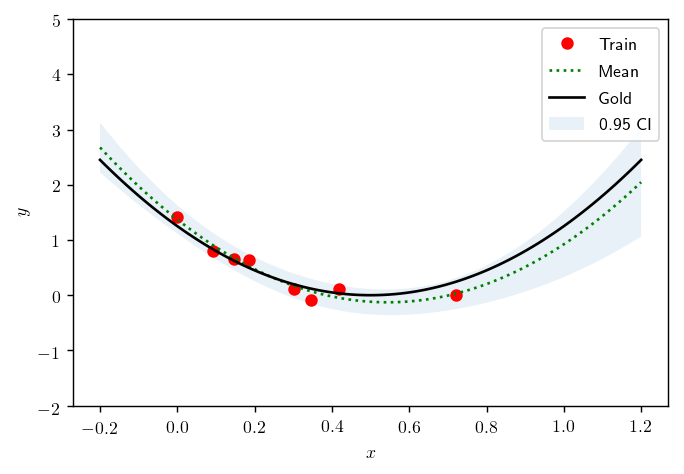

In [16]:
# Plot the 'obvious' choice

Phi_2, Phi_2_test = polynomial_features(X, X_test, 2)

w_N_2, V_N_2 = compute_posterior_params(Phi_2, Y, sigma, gamma)
Y_test_mean = target_mean(Phi_2_test, w_N_2)
Y_test_std = target_std(Phi_2_test, V_N_2, sigma)
    
plt.plot(X, Y, 'ro', label='Train')
plt.fill_between(X_test.ravel(), Y_test_mean + 2*Y_test_std, Y_test_mean - 2*Y_test_std, alpha=0.1, label='0.95 CI')
plt.plot(X_test.ravel(), Y_test_mean, 'g:', label='Mean')
plt.plot(X_test.ravel(), Y_test_gold, 'k', label='Gold')

plt.ylim(-2,5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

### 4. (Ext.) Bayesian regression with unknown variance

In real settings, the variance for $y$, $\sigma^2$ is unknown. For any general model, if we wish to predict $\ys^*$ for test data $\xs^*$ what we want is $p(\ys^* \vert \xs^*, X_{train})$ rather than $p(\ys^* \vert \xs^*, X_{train}, \gamma^2, \sigma^2)$ - i.e. stop conditioning on the variances for the weights and targets. 
It's possible to account for this by putting the following prior on $\sigma^{2}$:

$$
\sigma^{-2} \sim \textrm{Gamma}(\alpha, \beta)
$$
where $\alpha_1, \alpha_2 > 0$ are hyperparameters.

We can also put a prior over the variance for the weights, $\gamma^2$:

$$
\gamma^{-2} \sim \textrm{Gamma}(\lambda_1, \lambda_2)
$$
where $\lambda_1, \lambda_2 > 0$ are hyperparameters.

# 🤔

Wait a minute, doesn't this double the number of hyperparameters? Is it hyperparameters all the way down??? We usually set the hyperparameters to correspond to flat, uninformative priors over $\sigma^2$ and $\gamma^2$. Then perform Bayesian inference as follows with the additional priors:

$$ p(y^* \vert X_{train}, \xs^*) = \int \; d\sigma^2 \; d\gamma^2 \; d\ws \; p(y^* \vert \sigma^2, \xs^*, \ws) \; p(\ws, \sigma^2, \gamma^2 \vert X_{train}) $$

This model for regression (with the additional priors over $\gamma$ and $\sigma$) is implemented in `sklearn.linear_models.BayesianRidge`.

**Exercise**: Apply `BayesianRidge` to the training data (with the polynomial basis expansion) and compare the results to our simpler model.
What happens if the value of $\sigma$ used in our model deviates from the true value used to generate the data?
Is `BayesianRidge` more robust in this case?

**Answer:** Somewhat counter-intuitively, Bayesian ridge regression seems to give a more robust solution on this toy dataset compared to Bayesian regression with the true variance $\sigma^2$ known, even using the 'silly' feature transformation with polynomial order 9. **Very** loosely, the added uncertainty in the variances $\sigma^2, \gamma^2$ appear to have a regularizing effect on the predictive distribution. For more details, see M. E. Tipping, Sparse Bayesian Learning and the Relevance Vector Machine.

In [17]:
reg = BayesianRidge(compute_score=True, fit_intercept=False).fit(Phi, Y)

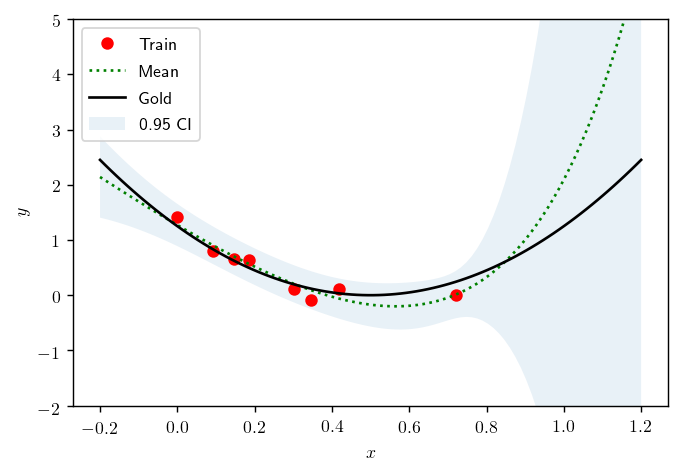

In [18]:
Y_test_mean, Y_test_std = reg.predict(Phi_test, return_std=True)  # Also returns standard deviation of predictive distribution

# Here we are using our original silly choice of Phi
plt.plot(X, Y, 'ro', label='Train')
plt.fill_between(X_test.ravel(), Y_test_mean + 2*Y_test_std, Y_test_mean - 2*Y_test_std, alpha=0.1, label='0.95 CI')
plt.plot(X_test, Y_test_mean, 'g:', label='Mean')
plt.plot(X_test, Y_test_gold, 'k', label='Gold')

plt.ylim(-2,5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()